In [10]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [11]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("train.csv")
print (train.shape)

(891, 12)


In [12]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [13]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,177
Cabin,687
Embarked,2


In [14]:
# Filling missing Age values with mean
train['Age'] = train['Age'].fillna(train['Age'].mean())

In [15]:
# Filling missing Embarked values with most common value
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [16]:
train['Pclass'] = train['Pclass'].apply(str)

In [17]:
# Getting Dummies from all other categorical vars
for col in train.dtypes[train.dtypes == 'object'].index:
   for_dummy = train.pop(col)
   train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [18]:
labels = train.pop('Survived')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)
 


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(x_train, y_train)

GradientBoostingClassifier()

In [20]:
y_pred = model.predict(x_test)

In [21]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7761258911493651

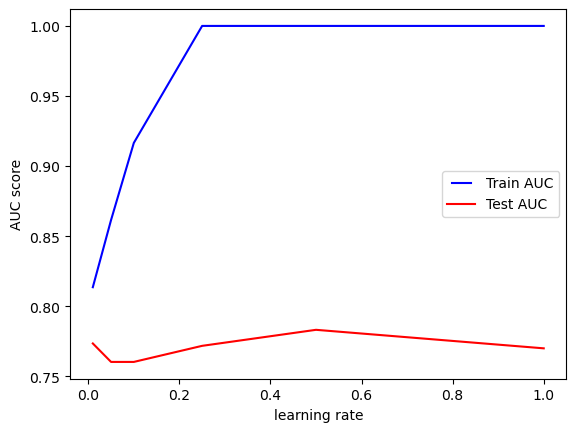

In [22]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

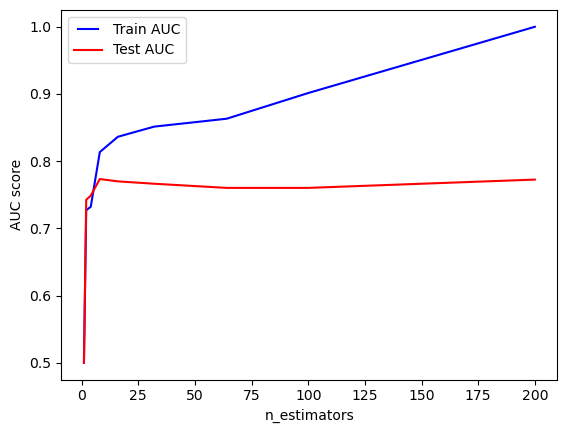

In [23]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [24]:
#!pip install hyperopt
#!pip install xgboost

In [25]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [26]:
def objective(space):

    print("Current max depth selected by algorithm: ",space['max_depth'])
    clf = xgb.XGBClassifier(n_estimators = 100,
                            max_depth = space['max_depth'],
#                            min_child_weight = space['min_child_weight'],
#                            subsample = space['subsample']
                           )

    eval_set  = [( x_train, y_train), ( x_val, y_val)]

    clf.fit(x_train, y_train,
            eval_set=eval_set, eval_metric="auc",
            early_stopping_rounds=3)

    pred = clf.predict_proba(x_val)[:,1]
    auc = roc_auc_score(y_val, pred)
    print ("SCORE:", auc)

    return{'loss':1-auc, 'status': STATUS_OK }


space ={
        'max_depth': hp.choice('max_depth', np.arange(5, 30+1, dtype=int))#,
        #'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        #'subsample': hp.uniform ('x_subsample', 0.8, 1)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

Current max depth selected by algorithm:                                                                               
26                                                                                                                     
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
10                                                                                                                     
  1%|▍                                  

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93445	validation_1-auc:0.83671                                                                  
[1]	validation_0-auc:0.94227	validation_1-auc:0.85722                                                                  
[2]	validation_0-auc:0.96475	validation_1-auc:0.84240                                                                  
[3]	validation_0-auc:0.97344	validation_1-auc:0.84347                                                                  
[4]	validation_0-auc:0.97879	validation_1-auc:0.82995                                                                  
SCORE:                                                                                                                 
0.8572196620583719                                                                                                     
Current max depth selected by algorithm:                                                                               
29                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
14                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
12                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
8                                                                                                                      
  5%|██▎                                

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92876	validation_1-auc:0.84178                                                                  
[1]	validation_0-auc:0.93884	validation_1-auc:0.85361                                                                  
[2]	validation_0-auc:0.95729	validation_1-auc:0.83909                                                                  
[3]	validation_0-auc:0.96841	validation_1-auc:0.84316                                                                  
SCORE:                                                                                                                 
0.853609831029186                                                                                                      
Current max depth selected by algorithm:                                                                               
23                                                                                                                     
  6%|██▊                                

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
19                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
20                                                                                                                     
  8%|███▊                               

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
26                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
20                                                                                                                     
 10%|████▌                              

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
14                                                                                                                     
 11%|█████                              

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
8                                                                                                                      
 12%|█████▌                             

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92876	validation_1-auc:0.84178                                                                  
[1]	validation_0-auc:0.93884	validation_1-auc:0.85361                                                                  
[2]	validation_0-auc:0.95729	validation_1-auc:0.83909                                                                  
[3]	validation_0-auc:0.96841	validation_1-auc:0.84316                                                                  
[4]	validation_0-auc:0.97539	validation_1-auc:0.82903                                                                  
SCORE:                                                                                                                 
0.853609831029186                                                                                                      
Current max depth selected by algorithm:                                                                               
14                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
19                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
29                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
7                                                                                                                      
 16%|███████▎                           

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92524	validation_1-auc:0.84347                                                                  
[1]	validation_0-auc:0.93291	validation_1-auc:0.85553                                                                  
[2]	validation_0-auc:0.95295	validation_1-auc:0.84700                                                                  
[3]	validation_0-auc:0.96278	validation_1-auc:0.84639                                                                  
[4]	validation_0-auc:0.96957	validation_1-auc:0.83310                                                                  
SCORE:                                                                                                                 
0.8555299539170508                                                                                                     
Current max depth selected by algorithm:                                                                               
26                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
25                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
5                                                                                                                      
 19%|████████▋                          

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.91006	validation_1-auc:0.83840                                                                  
[1]	validation_0-auc:0.91801	validation_1-auc:0.83126                                                                  
[2]	validation_0-auc:0.93009	validation_1-auc:0.83932                                                                  
[3]	validation_0-auc:0.93940	validation_1-auc:0.83495                                                                  
[4]	validation_0-auc:0.94930	validation_1-auc:0.82120                                                                  
[5]	validation_0-auc:0.95371	validation_1-auc:0.81928                                                                  
SCORE:                                                                                                                 
0.8393241167434716                                                                                                     
Current max depth selected by algorithm:

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93445	validation_1-auc:0.83671                                                                  
[1]	validation_0-auc:0.94227	validation_1-auc:0.85722                                                                  
[2]	validation_0-auc:0.96475	validation_1-auc:0.84240                                                                  
[3]	validation_0-auc:0.97344	validation_1-auc:0.84347                                                                  
[4]	validation_0-auc:0.97879	validation_1-auc:0.82995                                                                  
SCORE:                                                                                                                 
0.8572196620583719                                                                                                     
Current max depth selected by algorithm:                                                                               
10                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93445	validation_1-auc:0.83671                                                                  
[1]	validation_0-auc:0.94227	validation_1-auc:0.85722                                                                  
[2]	validation_0-auc:0.96475	validation_1-auc:0.84240                                                                  
[3]	validation_0-auc:0.97344	validation_1-auc:0.84347                                                                  
[4]	validation_0-auc:0.97879	validation_1-auc:0.82995                                                                  
SCORE:                                                                                                                 
0.8572196620583719                                                                                                     
Current max depth selected by algorithm:                                                                               
10                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93445	validation_1-auc:0.83671                                                                  
[1]	validation_0-auc:0.94227	validation_1-auc:0.85722                                                                  
[2]	validation_0-auc:0.96475	validation_1-auc:0.84240                                                                  
[3]	validation_0-auc:0.97344	validation_1-auc:0.84347                                                                  
SCORE:                                                                                                                 
0.8572196620583719                                                                                                     
Current max depth selected by algorithm:                                                                               
16                                                                                                                     
 23%|██████████▌                        

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
30                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
18                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
10                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93445	validation_1-auc:0.83671                                                                  
[1]	validation_0-auc:0.94227	validation_1-auc:0.85722                                                                  
[2]	validation_0-auc:0.96475	validation_1-auc:0.84240                                                                  
[3]	validation_0-auc:0.97344	validation_1-auc:0.84347                                                                  
SCORE:                                                                                                                 
0.8572196620583719                                                                                                     
Current max depth selected by algorithm:                                                                               
22                                                                                                                     
 27%|████████████▍                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
15                                                                                                                     
 28%|████████████▉                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                                                                                                      
 29%|█████████████▎                     

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
13                                                                                                                     
 30%|██████████████                     

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                                                                                                      
 31%|██████████████▌                    

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                                                                                                      
 32%|███████████████                    

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
[4]	validation_0-auc:0.97688	validation_1-auc:0.83510                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                                                                                                      
 34%|███████████████▉                   

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
[4]	validation_0-auc:0.97688	validation_1-auc:0.83510                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
17                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
21                                                                                                                     
 36%|████████████████▉                  

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
11                                                                                                                     
 37%|█████████████████▍                 

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
28                                                                                                                     
 38%|█████████████████▊                 

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
27                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
24                                                                                                                     
 40%|██████████████████▊                

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
6                                                                                                                      
 41%|███████████████████▎               

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92018	validation_1-auc:0.83810                                                                  
[1]	validation_0-auc:0.92668	validation_1-auc:0.85061                                                                  
[2]	validation_0-auc:0.94587	validation_1-auc:0.83902                                                                  
[3]	validation_0-auc:0.95769	validation_1-auc:0.83909                                                                  
[4]	validation_0-auc:0.96352	validation_1-auc:0.83172                                                                  
SCORE:                                                                                                                 
0.8506144393241168                                                                                                     
Current max depth selected by algorithm:                                                                               
12                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                                                                                                      
 43%|████████████████████▏              

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
23                                                                                                                     
 44%|████████████████████▋              

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
[4]	validation_0-auc:0.97688	validation_1-auc:0.83510                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
7                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92524	validation_1-auc:0.84347                                                                  
[1]	validation_0-auc:0.93291	validation_1-auc:0.85553                                                                  
[2]	validation_0-auc:0.95295	validation_1-auc:0.84700                                                                  
[3]	validation_0-auc:0.96278	validation_1-auc:0.84639                                                                  
SCORE:                                                                                                                 
0.8555299539170508                                                                                                     
Current max depth selected by algorithm:                                                                               
20                                                                                                                     
 47%|██████████████████████             

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
8                                                                                                                      
 48%|██████████████████████▌            

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92876	validation_1-auc:0.84178                                                                  
[1]	validation_0-auc:0.93884	validation_1-auc:0.85361                                                                  
[2]	validation_0-auc:0.95729	validation_1-auc:0.83909                                                                  
[3]	validation_0-auc:0.96841	validation_1-auc:0.84316                                                                  
[4]	validation_0-auc:0.97539	validation_1-auc:0.82903                                                                  
SCORE:                                                                                                                 
0.853609831029186                                                                                                      
Current max depth selected by algorithm:                                                                               
29                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
25                                                                                                                     
 50%|███████████████████████▌           

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
5                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.91006	validation_1-auc:0.83840                                                                  
[1]	validation_0-auc:0.91801	validation_1-auc:0.83126                                                                  
[2]	validation_0-auc:0.93009	validation_1-auc:0.83932                                                                  
[3]	validation_0-auc:0.93940	validation_1-auc:0.83495                                                                  
[4]	validation_0-auc:0.94930	validation_1-auc:0.82120                                                                  
SCORE:                                                                                                                 
0.8393241167434716                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
19                                                                                                                     
 53%|████████████████████████▉          

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
16                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
18                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
30                                                                                                                     
 56%|██████████████████████████▎        

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
26                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
15                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
22                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
13                                                                                                                     
 60%|████████████████████████████▏      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
27                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
28                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
14                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
17                                                                                                                     
 64%|██████████████████████████████     

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                                                                                                      
 65%|██████████████████████████████▌    

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
[4]	validation_0-auc:0.97688	validation_1-auc:0.83510                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
[4]	validation_0-auc:0.97688	validation_1-auc:0.83510                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
[4]	validation_0-auc:0.97688	validation_1-auc:0.83510                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
21                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
11                                                                                                                     
 69%|████████████████████████████████▍  

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
24                                                                                                                     
 70%|████████████████████████████████▉  

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
12                                                                                                                     
 72%|█████████████████████████████████▊ 

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
6                                                                                                                      
 73%|██████████████████████████████████▎

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92018	validation_1-auc:0.83810                                                                  
[1]	validation_0-auc:0.92668	validation_1-auc:0.85061                                                                  
[2]	validation_0-auc:0.94587	validation_1-auc:0.83902                                                                  
[3]	validation_0-auc:0.95769	validation_1-auc:0.83909                                                                  
[4]	validation_0-auc:0.96352	validation_1-auc:0.83172                                                                  
SCORE:                                                                                                                 
0.8506144393241168                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
29                                                                                                                     
 75%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
23                                                                                                                     
 76%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
7                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92524	validation_1-auc:0.84347                                                                  
[1]	validation_0-auc:0.93291	validation_1-auc:0.85553                                                                  
[2]	validation_0-auc:0.95295	validation_1-auc:0.84700                                                                  
[3]	validation_0-auc:0.96278	validation_1-auc:0.84639                                                                  
[4]	validation_0-auc:0.96957	validation_1-auc:0.83310                                                                  
SCORE:                                                                                                                 
0.8555299539170508                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
[4]	validation_0-auc:0.97688	validation_1-auc:0.83510                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
8                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.92876	validation_1-auc:0.84178                                                                  
[1]	validation_0-auc:0.93884	validation_1-auc:0.85361                                                                  
[2]	validation_0-auc:0.95729	validation_1-auc:0.83909                                                                  
[3]	validation_0-auc:0.96841	validation_1-auc:0.84316                                                                  
[4]	validation_0-auc:0.97539	validation_1-auc:0.82903                                                                  
SCORE:                                                                                                                 
0.853609831029186                                                                                                      
Current max depth selected by algorithm:                                                                               
20                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
25                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
5                                                                                                                      
 82%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.91006	validation_1-auc:0.83840                                                                  
[1]	validation_0-auc:0.91801	validation_1-auc:0.83126                                                                  
[2]	validation_0-auc:0.93009	validation_1-auc:0.83932                                                                  
[3]	validation_0-auc:0.93940	validation_1-auc:0.83495                                                                  
[4]	validation_0-auc:0.94930	validation_1-auc:0.82120                                                                  
SCORE:                                                                                                                 
0.8393241167434716                                                                                                     
Current max depth selected by algorithm:                                                                               
19                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
16                                                                                                                     
 84%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
30                                                                                                                     
 86%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
18                                                                                                                     
 87%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
26                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
22                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
13                                                                                                                     
 90%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
15                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
10                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93445	validation_1-auc:0.83671                                                                  
[1]	validation_0-auc:0.94227	validation_1-auc:0.85722                                                                  
[2]	validation_0-auc:0.96475	validation_1-auc:0.84240                                                                  
[3]	validation_0-auc:0.97344	validation_1-auc:0.84347                                                                  
SCORE:                                                                                                                 
0.8572196620583719                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                                                                                                      
 93%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
Current max depth selected by algorithm:                                                                               
21                                                                                                                     
 94%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
28                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
27                                                                                                                     
 96%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
14                                                                                                                     
 97%|███████████████████████████████████

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
17                                      

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93523	validation_1-auc:0.83502                                                                  
[1]	validation_0-auc:0.94252	validation_1-auc:0.85614                                                                  
[2]	validation_0-auc:0.96508	validation_1-auc:0.84224                                                                  
[3]	validation_0-auc:0.97334	validation_1-auc:0.84378                                                                  
[4]	validation_0-auc:0.97927	validation_1-auc:0.83057                                                                  
SCORE:                                                                                                                 
0.8561443932411675                                                                                                     
Current max depth selected by algorithm:                                                                               
9                                       

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Shay\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-auc:0.93380	validation_1-auc:0.83533                                                                  
[1]	validation_0-auc:0.94208	validation_1-auc:0.85768                                                                  
[2]	validation_0-auc:0.96354	validation_1-auc:0.84455                                                                  
[3]	validation_0-auc:0.97235	validation_1-auc:0.84731                                                                  
SCORE:                                                                                                                 
0.8576804915514593                                                                                                     
100%|██████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47trial/s, best loss: 0.1423195084485407]
{'max_depth': 4}
